In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_parquet("data/raw/france.parquet")
data.dropna(axis=0, how='any', inplace=True)

position = pd.read_csv("data/raw/postesSynop.csv", sep=";")

Id = position["ID"].astype(str)
for i in range(len(Id)):
    if len(Id[i]) < 5:
        Id[i] = '0' + Id[i]

production = pd.read_parquet("data/raw/franceagrimer-rdts-surfs-multicrops.parquet")
production = production.drop(production[production["n_dep"] == "2A"].index)
production = production.drop(production[production["n_dep"] == "2B"].index)
production = production.drop(production[production["n_dep"].astype(int) > 95].index)

provinces = {7005: 80, 7015: 59, 7020: 50, 7027: 14, 7037: 76, 7072: 51, 7110: 29, 7117: 22, 7130: 35, 7139: 61, 7149: 91, 7168: 10, 7181: 54, 7190: 67, 7207: 56, 7222: 44, 7240: 37, 7255: 18, 7280: 21, 7299: 68, 7314: 17, 7335: 86, 7434: 87, 7460: 63, 7471: 43, 7481: 69, 7510: 33, 7535: 46, 7558: 12, 7577: 26, 7591: 5, 7607: 40, 7621: 65, 7627: 9, 7630: 31, 7643: 34, 7650: 13, 7661: 83, 7690: 6, 7747: 66, 67005: 10}

crops = production["crop"].unique()
stations = data["id_sta"].unique()

In [3]:
lr = LinearRegression()

# Single element prediction

In [4]:
times = 1000

In [5]:
def init_y():
    for i in total_rain:
        n_dep0, year = i.split('_')
        r_year = production['n_dep'].map(lambda x : x == n_dep0)
        r_crop = production['crop'].map(lambda x : x == crop)
        rdt = production[r_year & r_crop]["rdt_" + year].values
        if rdt.size > 0:
            if rdt[0]:
                total_rdt[i] = rdt[0]

In [6]:
def init():
    init_y()
    return init_list()

In [7]:
def predict_zero():
    predict_zero = rdt_array.mean()
    
    RMSE = math.sqrt(((predict_zero - rdt_array) ** 2).sum() / len(rdt_array))
    rRMSE = RMSE / rdt_array.mean()
    
    return rRMSE

In [8]:
def predict_n(n, times):
    if n == 0:
        return predict_zero(), 0.0

    sum_RMSE = 0
    coef = np.array([0.0 for i in range(n)])
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, rdt_array, test_size=0.2)
        X_train_n = X_train
        X_test_n = X_test
        for i in range(2, n + 1):
            X_train_n = np.concatenate([X_train ** i, X_train_n], axis=1)
            X_test_n = np.concatenate([X_test ** i, X_test_n], axis=1)
        
        lr.fit(X_train_n, y_train)
        coef += lr.coef_
        y_predict_n = lr.predict(X_test_n)
        
        RMSE = math.sqrt(((y_predict_n - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times, coef / times

In [9]:
def test_degree_n(times):
    degree = np.linspace(start, end, end-start+1)
    for i in degree:
        rRMSE_degree[crop + i.astype(int).astype(str)], coeffs[crop + i.astype(int).astype(str)] = predict_n(i.astype(int), times)

In [10]:
def draw():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.xticks(np.arange(start, end + 1, 1))
    for crop in crops:
        rRMSE_plot = []
        x_plot = np.linspace(start, end, end-start+1)
        for i in range(start, end-start+1):
            rRMSE_plot.append(rRMSE_degree[crop + str(i)])
        plt.plot(x_plot, rRMSE_plot)
    plt.legend(crops)

## rr24

In [11]:
def init_x():
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                rain = 0
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        rain += data_station["rr24"][k]
                    else:
                        year_position = k
                        break
                total_rain[str(provinces[i]) + "_" + str(j)] = rain

In [12]:
def init_list():
    data_list = []
    rdt_list = []

    for i in total_rdt:
        if i in total_rain:
            data_list.append(np.array([total_rain[i]]))
            rdt_list.append(total_rdt[i])

    data_list = np.array(data_list)
    rdt_list = np.array(rdt_list)
    
    return data_list, rdt_list

In [13]:
start = 0
end = 10

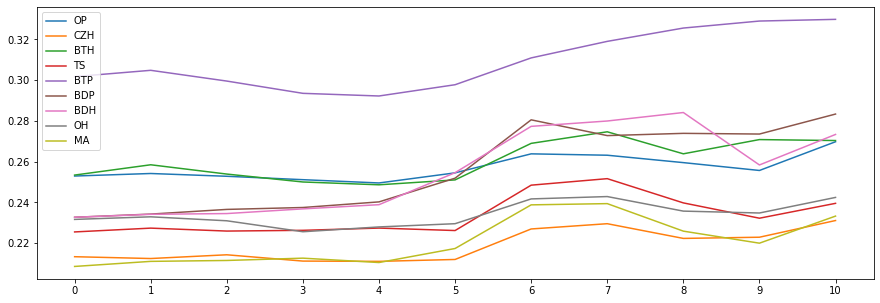

In [14]:
rRMSE_degree = {}
total_rain = {}
coeffs = {}
init_x()

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init()

    test_degree_n(times)

draw()

In [15]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(end - start + 1):
        temp_list.append(rRMSE_degree[crop + str(i)])
    best_predict[crop + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP4': 0.249527855618716,
 'CZH4': 0.21102005564832388,
 'BTH4': 0.24862587301216793,
 'TS0': 0.2254771996904205,
 'BTP4': 0.2922447961404022,
 'BDP0': 0.23267610695447274,
 'BDH0': 0.23267610695447274,
 'OH3': 0.22556934995457562,
 'MA0': 0.20852417057938513}

In [16]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP4': array([ 7.83372852e-11, -1.58032998e-07,  5.81565732e-05,  2.61929966e-02]),
 'CZH4': array([-6.41084853e-11,  1.99278268e-07, -2.11064345e-04,  8.19637835e-02]),
 'BTH4': array([ 3.23058048e-11, -5.10795460e-09, -1.17963295e-04,  1.05378613e-01]),
 'TS0': 0.0,
 'BTP4': array([ 1.02940068e-10, -1.70120382e-07, -1.07077121e-05,  9.20145237e-02]),
 'BDP0': 0.0,
 'BDH0': 0.0,
 'OH3': array([ 6.79344979e-08, -1.62848055e-04,  1.11826780e-01]),
 'MA0': 0.0}

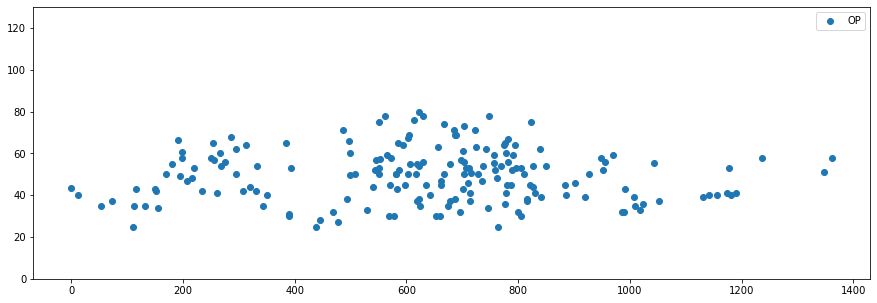

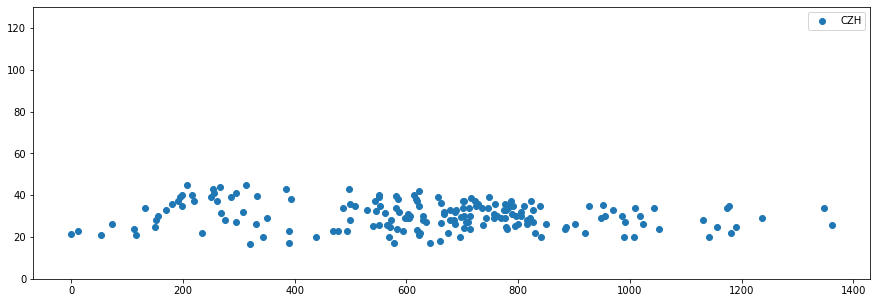

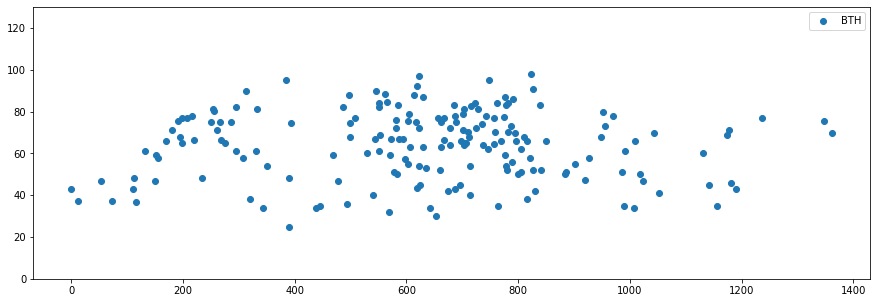

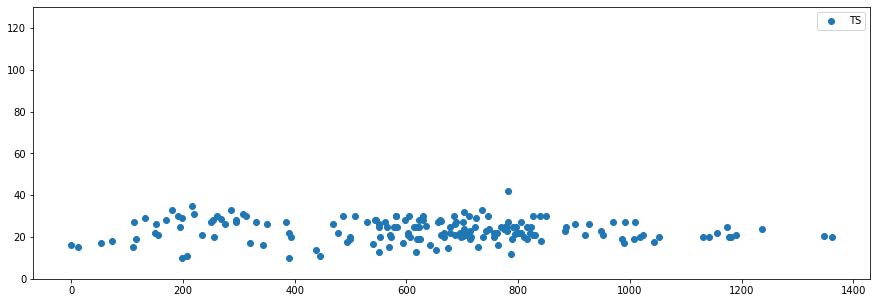

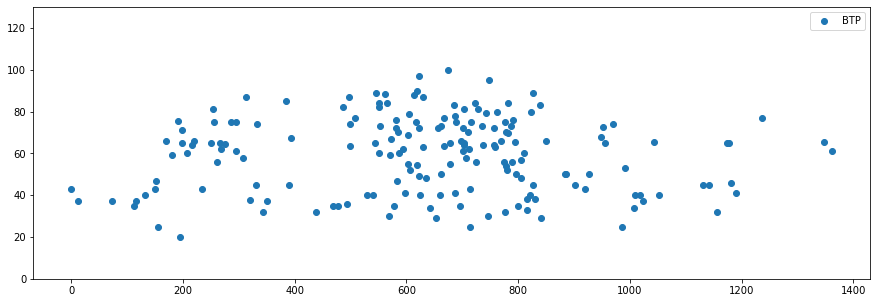

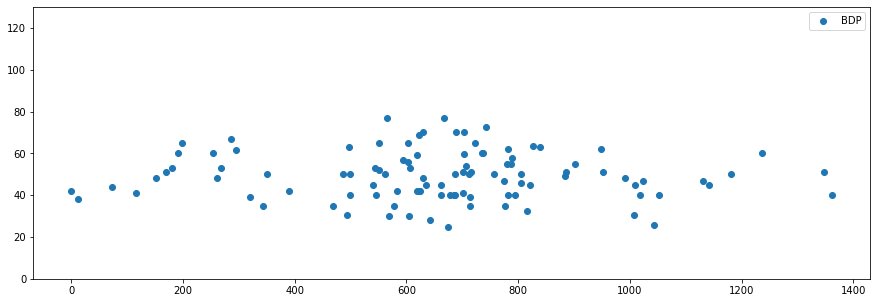

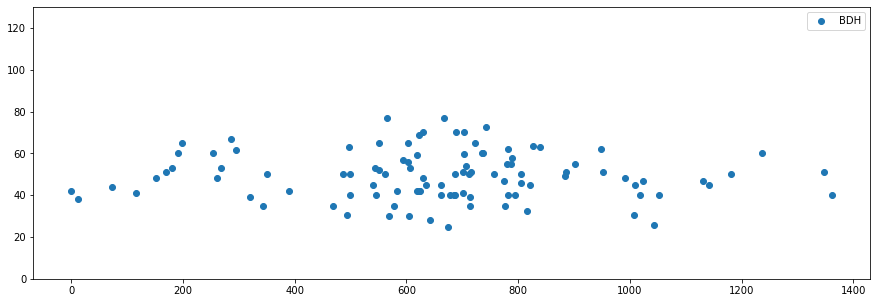

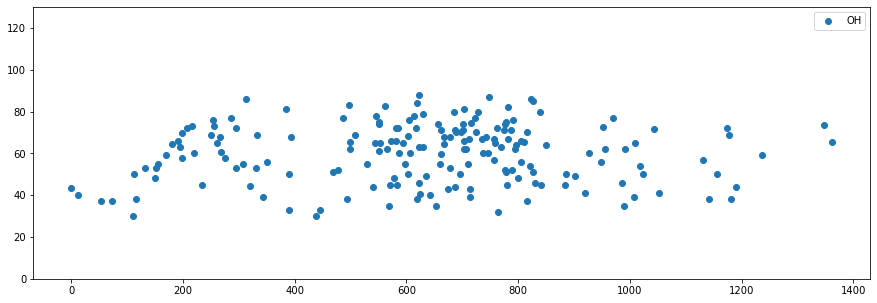

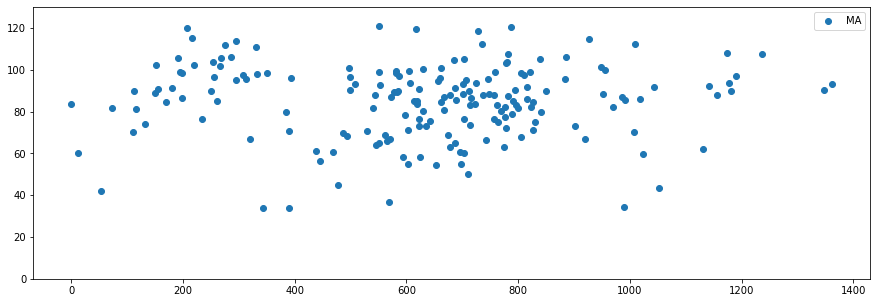

In [17]:
for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init()
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.ylim((0, 130))
    plt.scatter(data_array, rdt_array)
    plt.legend([crop])

## DJ_0

In [18]:
def init_x():
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                rad_0 = 0
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        rad_0 += data_station["DJ_0"][k]
                    else:
                        year_position = k
                        break
                total_rad_0[str(provinces[i]) + "_" + str(j)] = rad_0

In [19]:
def init_list():
    data_list = []
    rdt_list = []

    for i in total_rdt:
        if i in total_rad_0:
            data_list.append(np.array([total_rad_0[i]]))
            rdt_list.append(total_rdt[i])

    data_list = np.array(data_list)
    rdt_list = np.array(rdt_list)
    
    return data_list, rdt_list

In [20]:
start = 0
end = 20

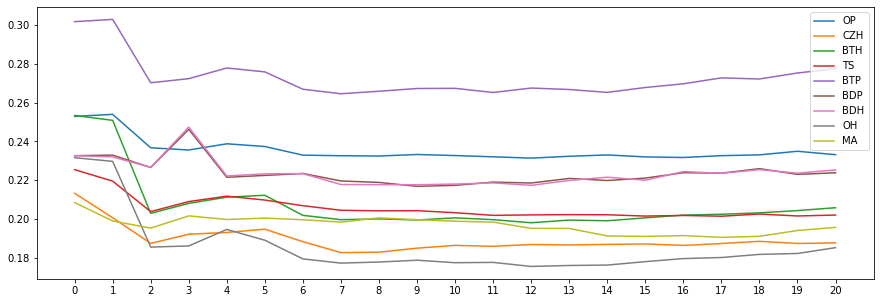

In [21]:
rRMSE_degree = {}
total_rad_0 = {}
coeffs = {}
init_x()

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init()

    test_degree_n(times)

draw()

In [22]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(end - start + 1):
        temp_list.append(rRMSE_degree[crop + str(i)])
    best_predict[crop + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP12': 0.2314168678564133,
 'CZH7': 0.18269424305232793,
 'BTH12': 0.1980909997553429,
 'TS17': 0.20145646721408134,
 'BTP7': 0.26458831044450826,
 'BDP9': 0.21686670845796885,
 'BDH12': 0.21739226342228674,
 'OH12': 0.17556574655279836,
 'MA17': 0.19057312151584704}

In [23]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP12': array([-2.77602304e-42,  5.06375796e-38, -3.06020447e-34,  6.11378628e-31,
         4.66422851e-34,  2.23478496e-37,  8.60380759e-41,  2.90704721e-44,
         8.97144132e-48,  2.56348554e-51,  6.64692399e-55,  1.37091406e-58]),
 'CZH7': array([ 1.16702474e-23, -1.81355619e-19,  9.30558393e-16, -1.58730270e-12,
        -1.28323167e-15, -6.30706350e-19, -2.16901291e-22]),
 'BTH12': array([-4.45815549e-42,  8.13021082e-38, -4.90883192e-34,  9.78483445e-31,
         7.47014385e-34,  3.58172449e-37,  1.37992566e-40,  4.66581038e-44,
         1.44095351e-47,  4.12040932e-51,  1.06927496e-54,  2.20816461e-58]),
 'TS17': array([ 2.48039862e-61, -4.04622959e-57,  2.20869499e-53, -4.05627063e-50,
        -2.96511055e-53, -1.35910458e-56, -5.00042889e-60, -1.61529316e-63,
        -4.78717405e-67, -1.33469535e-70, -3.55598631e-74, -9.14655634e-78,
        -2.28596167e-81, -5.56465388e-85, -1.31222212e-88, -2.91091681e-92,
        -5.30415952e-96]),
 'BTP7': array([ 2.42297388e-23, -3.629

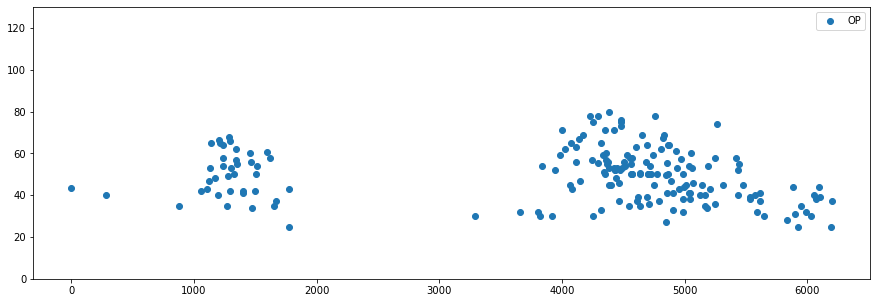

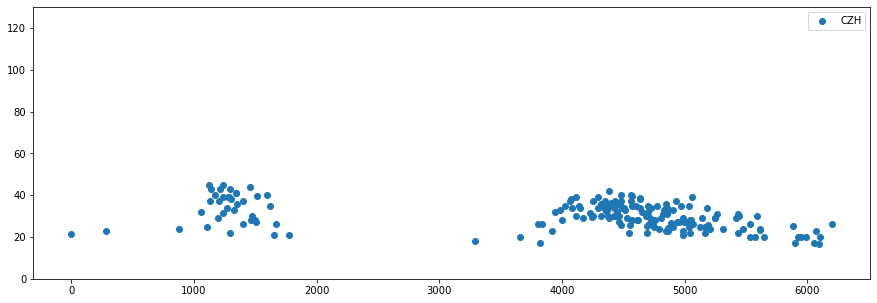

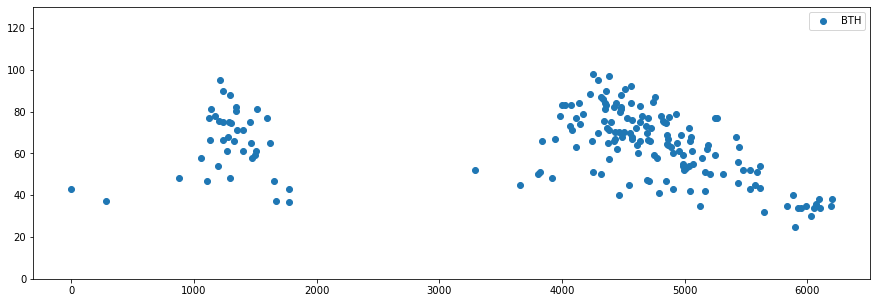

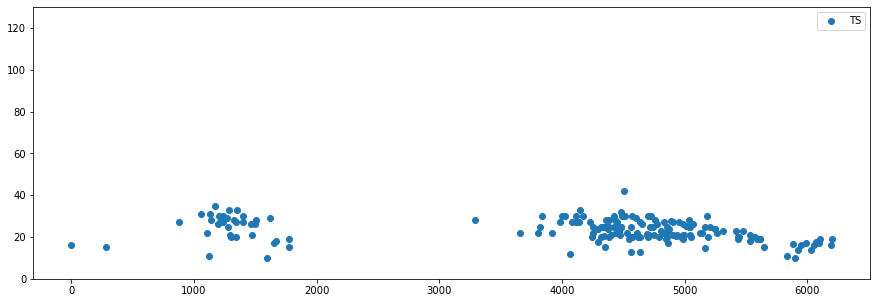

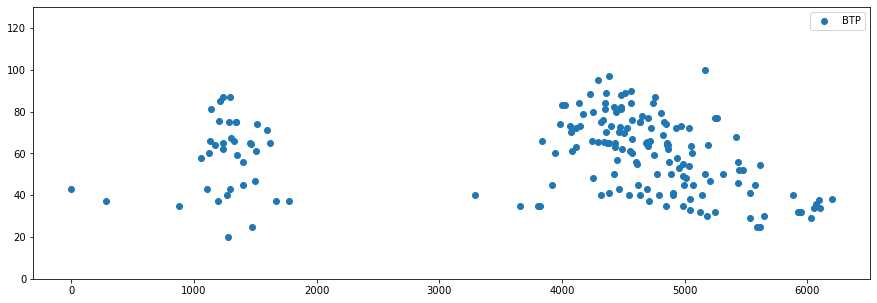

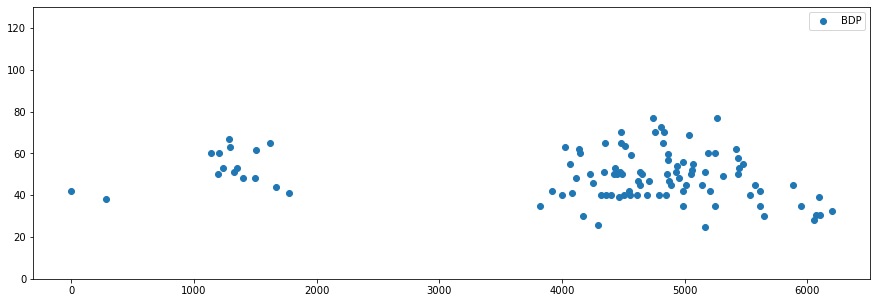

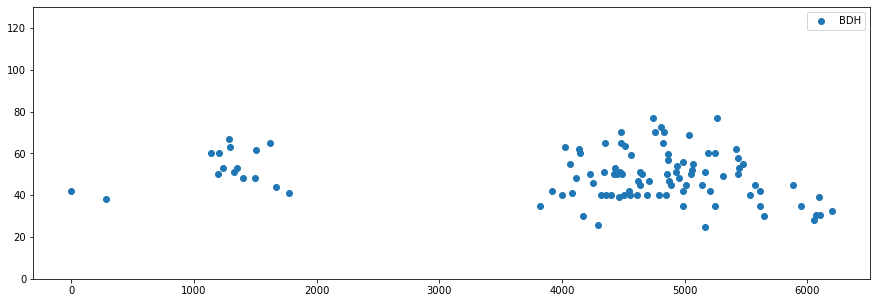

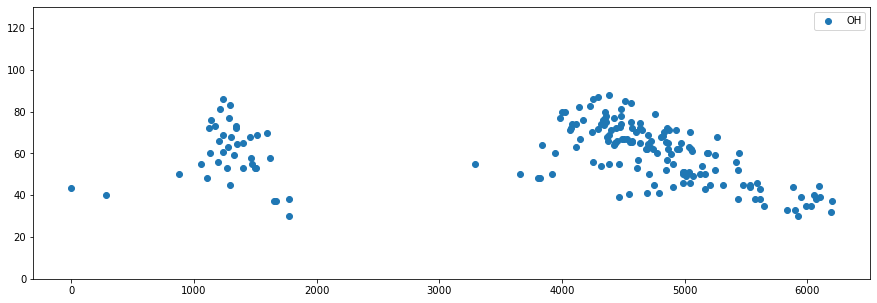

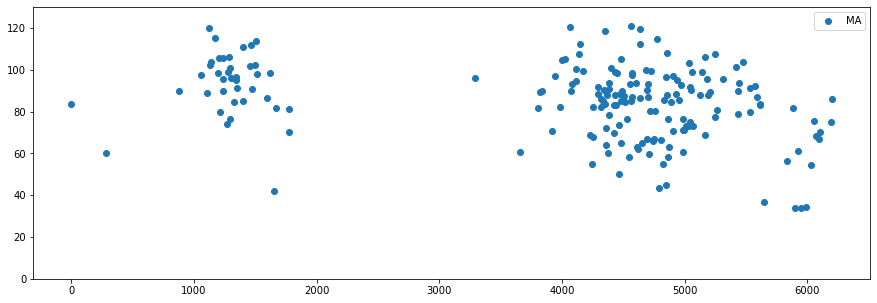

In [24]:
for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init()
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.ylim((0, 130))
    plt.scatter(data_array, rdt_array)
    plt.legend([crop])

## DJ_6

In [25]:
def init_x():
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                rad_6 = 0
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        rad_6 += data_station["DJ_6"][k]
                    else:
                        year_position = k
                        break
                total_rad_6[str(provinces[i]) + "_" + str(j)] = rad_6

In [26]:
def init_list():
    data_list = []
    rdt_list = []

    for i in total_rdt:
        if i in total_rad_6:
            data_list.append(np.array([total_rad_6[i]]))
            rdt_list.append(total_rdt[i])

    data_list = np.array(data_list)
    rdt_list = np.array(rdt_list)
    
    return data_list, rdt_list

In [27]:
start = 0
end = 20

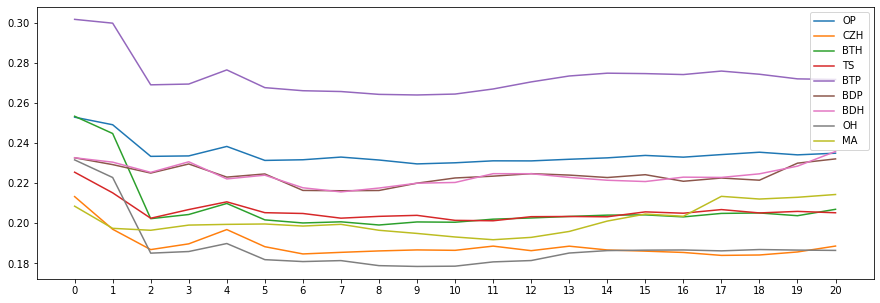

In [28]:
rRMSE_degree = {}
total_rad_6 = {}
coeffs = {}
init_x()

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init()

    test_degree_n(times)

draw()

In [29]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(end - start + 1):
        temp_list.append(rRMSE_degree[crop + str(i)])
    best_predict[crop + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP9': 0.2296233154637309,
 'CZH17': 0.18396828398591705,
 'BTH8': 0.19913598313836425,
 'TS11': 0.2012430305402211,
 'BTP9': 0.26401439838822804,
 'BDP7': 0.21621950027797784,
 'BDH7': 0.21564890531092357,
 'OH9': 0.1784534342781618,
 'MA11': 0.1917862491863793}

In [30]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP9': array([-1.61099119e-29,  1.82535302e-25, -6.83236677e-22,  8.39836235e-19,
         1.06145184e-21,  8.43408043e-25,  5.34079576e-28,  2.85425931e-31,
         1.17450295e-34]),
 'CZH17': array([ 1.37259874e-57, -1.57678219e-53,  6.06182730e-50, -7.80787839e-47,
        -8.87418216e-50, -6.32690454e-53, -3.62169721e-56, -1.82037139e-59,
        -8.39302721e-63, -3.63854680e-66, -1.50587375e-69, -6.00764324e-73,
        -2.32402208e-76, -8.73808126e-80, -3.18115183e-83, -1.09551044e-86,
        -3.16031126e-90]),
 'BTH8': array([-3.42987742e-26,  4.31701196e-22, -1.76562146e-18,  2.32103724e-15,
         2.97964701e-18,  2.38084717e-21,  1.46658240e-24,  6.65034607e-28]),
 'TS11': array([ 4.78627962e-37, -4.72328000e-33,  1.55376386e-29, -1.73297486e-26,
        -2.10759870e-29, -1.61533881e-32, -9.98053649e-36, -5.42362302e-39,
        -2.68584776e-42, -1.20624142e-45, -4.37299962e-49]),
 'BTP9': array([-3.06580263e-29,  3.47406322e-25, -1.29948857e-21,  1.59614499e-18,
       

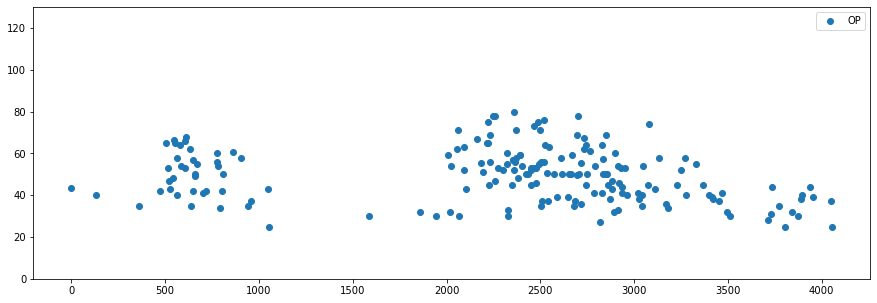

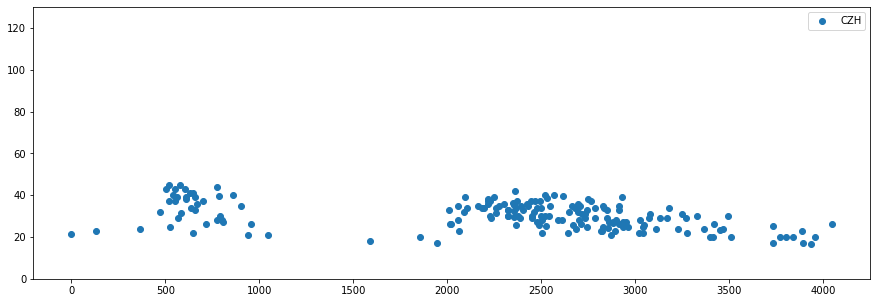

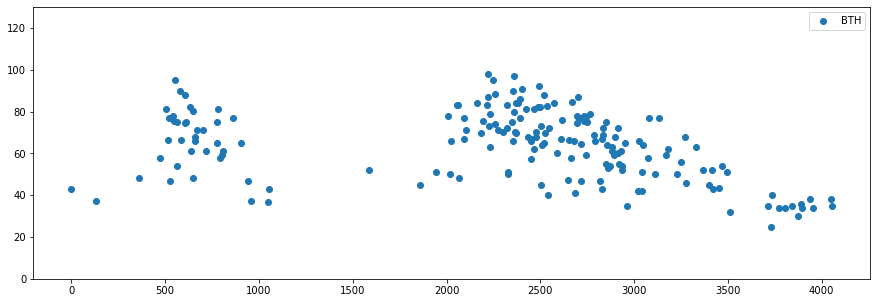

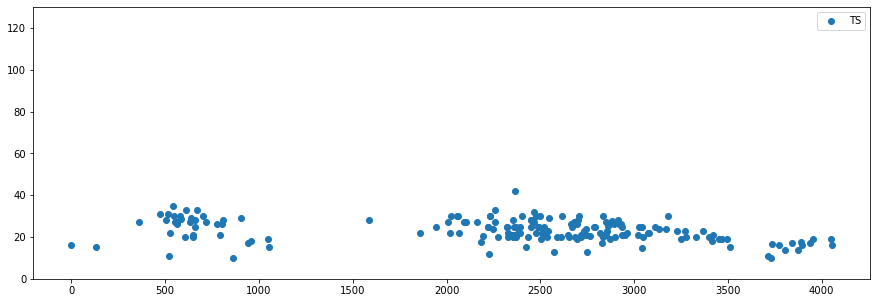

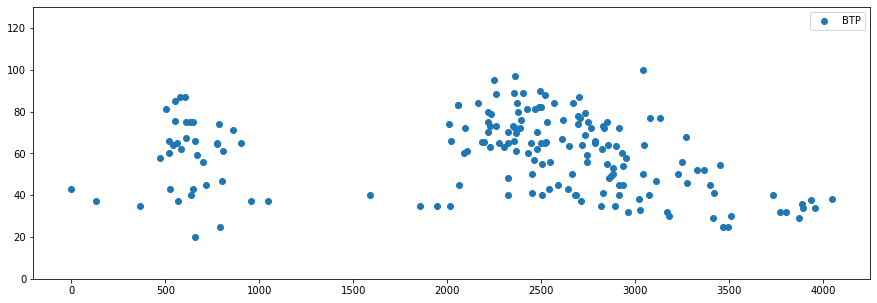

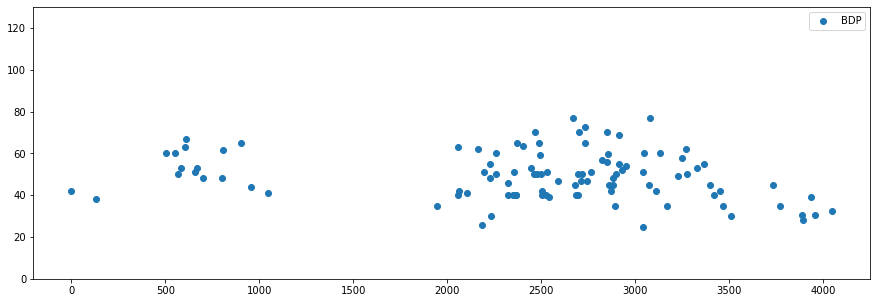

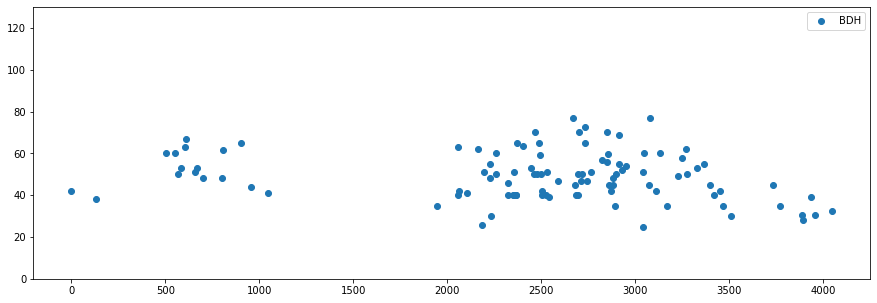

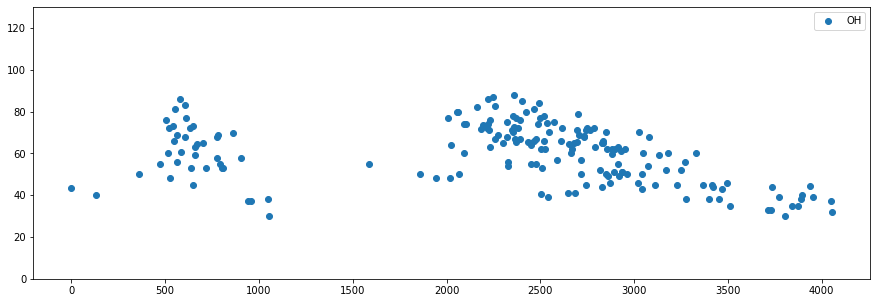

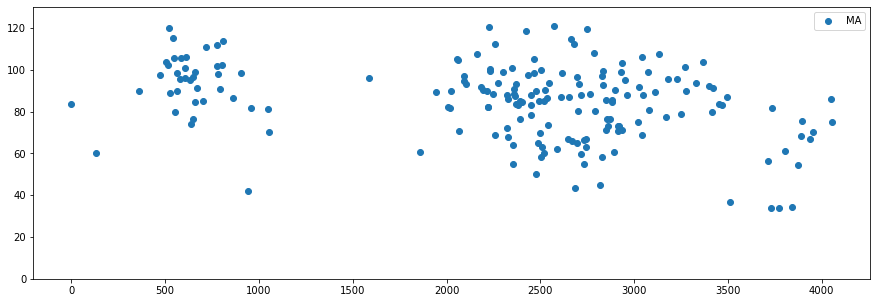

In [31]:
for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init()
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.ylim((0, 130))
    plt.scatter(data_array, rdt_array)
    plt.legend([crop])